In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from google.colab import drive
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
movies = pd.read_csv('/content/gdrive/MyDrive/Kaggle/movies2.csv')
tags = pd.read_csv('/content/gdrive/MyDrive/Kaggle/tags.csv')
ratings = pd.read_csv('/content/gdrive/MyDrive/Kaggle/ratings.csv')
links = pd.read_csv('/content/gdrive/MyDrive/Kaggle/links.csv')

In [4]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [6]:
ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [7]:
links

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0
...,...,...,...
9737,193581,5476944,432131.0
9738,193583,5914996,445030.0
9739,193585,6397426,479308.0
9740,193587,8391976,483455.0


Menggabungkan seluruh movieId pada kategori movie,kemudian mengurutkan data dan mengambil data yang unik(tidak sama dengan yg lain)

In [8]:
all_movies = np.concatenate((
    movies.movieId.unique(),
    tags.movieId.unique(),
    ratings.movieId.unique(),
    links.movieId.unique(),
))

all_movies = np.sort(np.unique(all_movies))

In [9]:
print('number of all movies: ', len(all_movies))

number of all movies:  9742


Menggabungkan semua userId pada users, dalam hal ini userId pada file tags dan ratings, kemudian mengambil nilai unik pada users yang diurutkan

In [10]:
users = np.concatenate((
    tags.userId.unique(),
    ratings.userId.unique(),
))

users = np.sort(np.unique(users))
print('number of all users: ', len(users))

number of all users:  610


Dapat dilihat pada jumlah seluruh pengguna ada sekitar 610

Menggabungkan movies,tags,ratings, dan links pada movinfo. Kemudian di merge ratings dan movinfo dengan left join (dalam hal ini mengambil data ratings(df kiri(left)) dan membuang baris dari df kanan yang tidak memiliki kecocokan dikolom kunci df kiri(left)).

In [11]:
movinfo= pd.concat([ movies, tags, ratings, links])
movie = pd.merge(ratings, movinfo, on='movieId', how='left')
movie.head()

,userId_x,movieId,rating_x,timestamp_x,title,genres,userId_y,tag,timestamp_y,rating_y,imdbId,tmdbId
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,4.0,964982703,NaN,NaN,336.0,pixar,1.139046e+09,NaN,NaN,NaN
2,1,1,4.0,964982703,NaN,NaN,474.0,pixar,1.137207e+09,NaN,NaN,NaN
3,1,1,4.0,964982703,NaN,NaN,567.0,fun,1.525286e+09,NaN,NaN,NaN
4,1,1,4.0,964982703,NaN,NaN,1.0,NaN,9.649827e+08,4.0,NaN,NaN


Untuk melihat banyaknya baris dan kolom bisa menggunakan shape

In [12]:
movie.shape

(6359585, 12)

Setelah digabungkan digroupby berdasarkan movieId

In [13]:
movie.groupby('movieId').sum()

<ipython-input-13-906aff00c8b5>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  movie.groupby('movieId').sum()


,userId_x,rating_x,timestamp_x,userId_y,timestamp_y,rating_y,imdbId,tmdbId
movieId,,,,,,,,
1,14498880,185460.0,53441180205380,14465415.0,5.304394e+13,181245.0,24662435.0,185330.0
2,4205116,43790.0,14492875665352,4060210.0,1.437287e+13,41525.0,12484670.0,972840.0
3,825832,9492.0,2926881125616,796900.0,2.836734e+12,8814.0,5887856.0,811304.0
4,13851,148.5,56610468432,10773.0,4.403036e+10,115.5,804195.0,219499.0
5,777987,7976.5,2577949287482,765723.0,2.494850e+12,7374.5,5539009.0,581238.0
...,...,...,...,...,...,...,...,...
193581,552,12.0,4611327246,184.0,1.537109e+09,4.0,5476944.0,432131.0
193583,552,10.5,4611328635,184.0,1.537110e+09,3.5,5914996.0,445030.0
193585,552,10.5,4611329415,184.0,1.537110e+09,3.5,6397426.0,479308.0


Melakukan merge ratings dan movies dengan left join (dalam hal ini mengambil data ratings(df kiri(left)) dan membuang baris dari df kanan yang tidak memiliki kecocokan dikolom kunci df kiri(left)) dalam hal ini berdasarkan movieId dan disimpan di df movies_names.

In [14]:
movies_names = pd.merge(ratings, movies[['movieId','title','genres']], on='movieId', how='left')
movies_names

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
...,...,...,...,...,...,...
100831,610,166534,4.0,1493848402,Split (2017),Drama|Horror|Thriller
100832,610,168248,5.0,1493850091,John Wick: Chapter Two (2017),Action|Crime|Thriller
100833,610,168250,5.0,1494273047,Get Out (2017),Horror
100834,610,168252,5.0,1493846352,Logan (2017),Action|Sci-Fi


Melakukan penggabungan data movies_name dan tags dengan left join berdasarkan movieId

In [15]:
movies_merge = pd.merge(movies_names, tags[['movieId','tag']], on='movieId', how='left')
movies_merge

,userId,movieId,rating,timestamp,title,genres,tag
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar
1,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar
2,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,fun
3,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance,moldy
4,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance,old
...,...,...,...,...,...,...,...
285757,610,168252,5.0,1493846352,Logan (2017),Action|Sci-Fi,emotional
285758,610,168252,5.0,1493846352,Logan (2017),Action|Sci-Fi,gritty
285759,610,168252,5.0,1493846352,Logan (2017),Action|Sci-Fi,heartbreaking
285760,610,168252,5.0,1493846352,Logan (2017),Action|Sci-Fi,predictible plot


Pada output diatas masih terdapat nilai NaN, maka dicek menggunakan isnull apakah masih ada missing values

In [16]:
movies_merge.isnull().sum()

userId           0
movieId          0
rating           0
timestamp        0
title            0
genres           0
tag          52549
dtype: int64

Dapat dilihat pada output diatas bahwa terdapat missing values sekitar 52549 pada kolom tags,maka bisa menggunakan dropna() untuk menghapus missing values yang direpresentasikan dengan Nan.

In [17]:
movies_merge = movies_merge.dropna()
movies_merge

,userId,movieId,rating,timestamp,title,genres,tag
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar
1,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar
2,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,fun
3,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance,moldy
4,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance,old
...,...,...,...,...,...,...,...
285756,610,168252,5.0,1493846352,Logan (2017),Action|Sci-Fi,dark
285757,610,168252,5.0,1493846352,Logan (2017),Action|Sci-Fi,emotional
285758,610,168252,5.0,1493846352,Logan (2017),Action|Sci-Fi,gritty
285759,610,168252,5.0,1493846352,Logan (2017),Action|Sci-Fi,heartbreaking


Setelah menghapus dengan dropna() cek kembali apakah masih ada missing values

In [18]:
movies_merge.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
title        0
genres       0
tag          0
dtype: int64

Pada output diatas bisa dilihat bahwa sudah tidak ada missing values

Menyimpan data yang tidak ada missing values pada movies_merge yang di urutkan(sort) berdasarkan movieId

In [19]:
movies_merge = movies_merge.sort_values('movieId', ascending=True)
movies_merge

,userId,movieId,rating,timestamp,title,genres,tag
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar
121430,275,1,5.0,1049076484,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar
121431,275,1,5.0,1049076484,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar
121432,275,1,5.0,1049076484,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,fun
35190,73,1,4.5,1464196374,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,fun
...,...,...,...,...,...,...,...
263644,586,187595,5.0,1529899556,Solo: A Star Wars Story (2018),Action|Adventure|Children|Sci-Fi,star wars
81531,184,193565,3.5,1537098554,Gintama: The Movie (2010),Action|Animation|Comedy|Sci-Fi,anime
81532,184,193565,3.5,1537098554,Gintama: The Movie (2010),Action|Animation|Comedy|Sci-Fi,comedy
81534,184,193565,3.5,1537098554,Gintama: The Movie (2010),Action|Animation|Comedy|Sci-Fi,remaster


Setelah diurutkan terdapat sekitar 233213 baris

Membuang data duplikat dengan drop_duplicates pada movieId,sehingga movieId tidak ada yang sama

In [20]:
movies_merge = movies_merge.drop_duplicates('movieId')
movies_merge

,userId,movieId,rating,timestamp,title,genres,tag
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar
187260,414,2,3.0,961594981,Jumanji (1995),Adventure|Children|Fantasy,fantasy
106951,240,3,4.0,849122858,Grumpier Old Men (1995),Comedy|Romance,old
19921,45,5,3.0,959625102,Father of the Bride Part II (1995),Comedy,pregnancy
115692,262,7,3.0,840306238,Sabrina (1995),Comedy|Romance,remake
...,...,...,...,...,...,...,...
27632,62,183611,4.0,1526244681,Game Night (2018),Action|Comedy|Crime|Horror,Comedy
174264,380,184471,3.0,1536872748,Tomb Raider (2018),Action|Adventure|Fantasy,Alicia Vikander
44721,98,187593,5.0,1532457913,Deadpool 2 (2018),Action|Comedy|Sci-Fi,sarcasm
263643,586,187595,5.0,1529899556,Solo: A Star Wars Story (2018),Action|Adventure|Children|Sci-Fi,Emilia Clarke


Mengkonversi movieId,title, dan genres dalam dalam bentuk list dan disimpan di id, names, dan genres

In [21]:
id = movies_merge['movieId'].tolist()
names = movies_merge['title'].tolist()
genres = movies_merge['genres'].tolist()

Membuat df baru dengan nama new_movies yang menyimpan id, names, dan genres

In [22]:
new_movies = pd.DataFrame({
    'id': id,
    'names': names,
    'genres': genres
})
new_movies.head()

,id,names,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,5,Father of the Bride Part II (1995),Comedy
4,7,Sabrina (1995),Comedy|Romance


In [23]:
new_movies.shape

(1554, 3)

Terdapat sekitar 1554 film pada df new_movies

Melakukan perhitungan idf pada data genre
Mapping array dari fitur index integer ke fitur nama

In [24]:
tf = TfidfVectorizer()
tf.fit(new_movies['genres'])
tf.get_feature_names_out()

array(['action', 'adventure', 'animation', 'children', 'comedy', 'crime',
       'documentary', 'drama', 'fantasy', 'fi', 'film', 'genres',
       'horror', 'imax', 'listed', 'musical', 'mystery', 'no', 'noir',
       'romance', 'sci', 'thriller', 'war', 'western'], dtype=object)

In [25]:
tfidf_matrix = tf.fit_transform(new_movies['genres'])
tfidf_matrix.shape

(1554, 24)

Matriks yang dimiliki berukuran (1554,24) Dimana nilai 1554 merupakan ukuran data dan 24 adalah banyaknya kategori genres

Untuk menghasilkan dalam bentuk matriks, digunakan fungsi todense()

In [26]:
tfidf_matrix.todense()

matrix([[0.        , 0.3983147 , 0.52247057, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.49497089, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.49413097, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.39639614, 0.40792706, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.41107716, 0.        , 0.55489644, ..., 0.        , 0.        ,
         0.        ]])

Selanjutnya jika ingin melihat matriks tfidf untuk beberapa nama film (disini saya menampilkan 10 nama film)berdasarkan genres

In [27]:
pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tf.get_feature_names_out(),
    index=new_movies.names
).sample(22, axis=1).sample(10, axis=0)

,romance,imax,fi,film,fantasy,thriller,animation,noir,documentary,horror,...,no,genres,comedy,mystery,sci,adventure,western,action,listed,war
names,,,,,,,,,,,,,,,,,,,,,
Shine (1996),0.846843,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000
"Secret Lives of Dentists, The (2002)",0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000
Up (2009),0.000000,0.0,0.000000,0.0,0.0,0.0,0.608575,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.000000,0.463958,0.0,0.000000,0.0,0.000000
Donnie Brasco (1997),0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000
"Americanization of Emily, The (1964)",0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.43864,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.836166
On Golden Pond (1981),0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000
Requiem for a Dream (2000),0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000
Who Killed Chea Vichea? (2010),0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,...,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000
Indiana Jones and the Last Crusade (1989),0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.000000,0.717170,0.0,0.696898,0.0,0.000000


Cosine Similarity

In [28]:
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1.        , 0.80472348, 0.1808617 , ..., 0.10142228, 0.42942348,
        0.37429223],
       [0.80472348, 1.        , 0.        , ..., 0.        , 0.53362862,
        0.        ],
       [0.1808617 , 0.        , 1.        , ..., 0.23089549, 0.        ,
        0.19208644],
       ...,
       [0.10142228, 0.        , 0.23089549, ..., 1.        , 0.6983388 ,
        0.83191943],
       [0.42942348, 0.53362862, 0.        , ..., 0.6983388 , 1.        ,
        0.58096161],
       [0.37429223, 0.        , 0.19208644, ..., 0.83191943, 0.58096161,
        1.        ]])

Untuk melihat matriks kesamaan setiap film, dibawah ini akan menampilkan nama film dalam 5 sampel kolom(axis =1) dan 10 sampel baris(axis = 0)

In [29]:
cosine_sim_data = pd.DataFrame(cosine_sim, index=new_movies['names'], columns=new_movies['names'])
print('Shape:', cosine_sim_data.shape)
cosine_sim_data.sample(5, axis=1).sample(10, axis=0)

Shape: (1554, 1554)


names,When Harry Met Sally... (1989),"Wonderful, Horrible Life of Leni Riefenstahl, The (Macht der Bilder: Leni Riefenstahl, Die) (1993)",Angie (1994),Dream for an Insomniac (1996),"Chronicles of Narnia: Prince Caspian, The (2008)"
names,,,,,
Kiss Me Goodbye (1982),0.641674,0.0,0.578103,0.000000,0.000000
Serpico (1973),0.000000,0.0,0.200577,0.245816,0.000000
Monster (2003),0.000000,0.0,0.200577,0.245816,0.000000
Cape Fear (1962),0.000000,0.0,0.157993,0.193627,0.000000
Self/less (2015),0.000000,0.0,0.000000,0.000000,0.000000
My Left Foot (1989),0.000000,0.0,0.433964,0.531842,0.000000
Alice Doesn't Live Here Anymore (1974),0.649510,0.0,0.815964,1.000000,0.000000
"Place in the Sun, A (1951)",0.649510,0.0,0.815964,1.000000,0.000000
"Grand Day Out with Wallace and Gromit, A (1989)",0.168214,0.0,0.151549,0.000000,0.484616


Membuat fungsi rekomendasi dengan parameter sbb:
movies_name, similarity_data, items, dan k

In [30]:
def movrecomm(movies_name, similarity_data=cosine_sim_data, items=new_movies[['names', 'genres']], k=3):
    index = similarity_data.loc[:,movies_name].to_numpy().argpartition(
        range(-1, -k, -1))
    closest = similarity_data.columns[index[-1:-(k+2):-1]]
    closest = closest.drop(movies_name, errors='ignore')
    return pd.DataFrame(closest).merge(items).head(k)

In [31]:
new_movies[new_movies.names.eq('The Hobbit: The Battle of the Five Armies (2014)')]

,id,names,genres
1497,118696,The Hobbit: The Battle of the Five Armies (2014),Adventure|Fantasy


In [32]:
movrecomm('The Hobbit: The Battle of the Five Armies (2014)')

,names,genres
0,"Lord of the Rings: The Two Towers, The (2002)",Adventure|Fantasy
1,Harry Potter and the Chamber of Secrets (2002),Adventure|Fantasy
2,Excalibur (1981),Adventure|Fantasy


In [33]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

Data Understanding Collaborative Filter

In [34]:
dataf = ratings
dataf

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


data ratings memiliki 100836 baris dan 4 kolom

Encode fitur user

In [35]:
userid = dataf['userId'].unique().tolist()
user_to_user_encoded = {x: i for i, x in enumerate(userid)}
user_encoded_to_user = {i: x for i, x in enumerate(userid)}

 Mengubah movieId menjadi list tanpa nilai yang sama
 Melakukan proses encoding movieId
 Melakukan proses encoding angka ke movieId
 Selanjutnya, petakan userId dan movieId ke dataframe yang berkaitan.

In [36]:
movieid = dataf['movieId'].unique().tolist()
movie_to_movie_encoded = {x: i for i, x in enumerate(movieid)}
movie_encoded_to_movie = {i: x for i, x in enumerate(movieid)}

dataf['users'] = dataf['userId'].map(user_to_user_encoded)
dataf['movies'] = dataf['movieId'].map(movie_to_movie_encoded)

Mengecek jumlah users dan movie, dan mengubah nilai ratings menjadi float

In [37]:
num_users = len(user_to_user_encoded)
num_movie = len(movie_encoded_to_movie)

dataf['ratings'] = dataf['rating'].values.astype(np.float32)

min_rating = min(dataf['rating'])
max_rating = max(dataf['rating'])

Mencetak ada berapa banyak user dan film serta nilai rating minimum dan maksimum

In [38]:
print('Number of User: {}, Number of Movie: {}, Min Rating: {}, Max Rating: {}'.format(num_users, num_movie, min_rating, max_rating))

Number of User: 610, Number of Movie: 9724, Min Rating: 0.5, Max Rating: 5.0


Mengacak data agar distribusinya random disimpan pada dataframe dataf

In [39]:
dataf = dataf.sample(frac=1, random_state=42)
dataf

,userId,movieId,rating,timestamp,users,movies,ratings
67037,432,77866,4.5,1335139641,431,4730,4.5
42175,288,474,3.0,978465565,287,474,3.0
93850,599,4351,3.0,1498524542,598,2631,3.0
6187,42,2987,4.0,996262677,41,194,4.0
12229,75,1610,4.0,1158989841,74,727,4.0
...,...,...,...,...,...,...,...
6265,42,4005,4.0,996259059,41,1873,4.0
54886,364,141,4.0,869443367,363,524,4.0
76820,480,6867,4.0,1179163171,479,2240,4.0
860,6,981,3.0,845556567,5,712,3.0


Memetakan data genres dan movies menjadi satu value,membuat variabel y untuk membuat ratings, membagi data menjadi 70% data train dan 30% data validasi

In [40]:
x = dataf[['users', 'movies']].values
y = dataf['ratings'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

train_indexes = int(0.7 * dataf.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indexes],
    x[train_indexes:],
    y[:train_indexes],
    y[train_indexes:]
)

print(x, y)

[[ 431 4730]
 [ 287  474]
 [ 598 2631]
 ...
 [ 479 2240]
 [   5  712]
 [ 102 2046]] [0.88888889 0.55555556 0.55555556 ... 0.77777778 0.55555556 1.        ]


Proses Training

In [41]:
class RecommenderNet(tf.keras.Model):

  def __init__(self, num_users, num_movie, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_movie = num_movie
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding(
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1)
    self.movie_embedding = layers.Embedding(
        num_movie,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.movie_bias = layers.Embedding(num_movie, 1)

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0])
    user_bias = self.user_bias(inputs[:, 0])
    movie_vector = self.movie_embedding(inputs[:, 1])
    movie_bias = self.movie_bias(inputs[:, 1])

    dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)

    x = dot_user_movie + user_bias + movie_bias

    return tf.nn.sigmoid(x)

Compile model, menggunakan metrik evaluasi RMSE(RootMeanSquaredError)

In [42]:
model = RecommenderNet(num_users, num_movie, 50)
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

Training

In [43]:
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 64,
    epochs = 100,
    validation_data = (x_val, y_val)
)

Epoch 1/100
1103/1103 [==============================] - 11s 8ms/step - loss: 0.6416 - root_mean_squared_error: 0.2374 - val_loss: 0.6210 - val_root_mean_squared_error: 0.2163
Epoch 2/100
1103/1103 [==============================] - 10s 9ms/step - loss: 0.6163 - root_mean_squared_error: 0.2110 - val_loss: 0.6204 - val_root_mean_squared_error: 0.2152
Epoch 3/100
1103/1103 [==============================] - 9s 8ms/step - loss: 0.6101 - root_mean_squared_error: 0.2044 - val_loss: 0.6151 - val_root_mean_squared_error: 0.2098
Epoch 4/100
1103/1103 [==============================] - 9s 8ms/step - loss: 0.6073 - root_mean_squared_error: 0.2014 - val_loss: 0.6137 - val_root_mean_squared_error: 0.2084
Epoch 5/100
1103/1103 [==============================] - 10s 9ms/step - loss: 0.6069 - root_mean_squared_error: 0.2008 - val_loss: 0.6115 - val_root_mean_squared_error: 0.2061
Epoch 6/100
1103/1103 [==============================] - 9s 8ms/step - loss: 0.6072 - root_mean_squared_error: 0.2009 - va

Visualisasi Metrik dengan plot

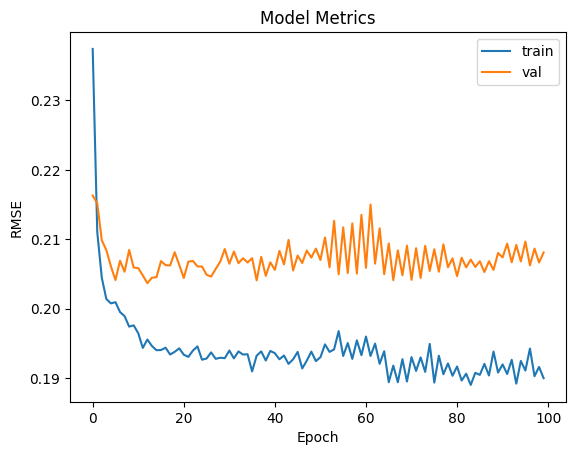

In [44]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('Model Metrics')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

Rekomendasi berdasarkan collaborative filtering

In [45]:
movies_data = new_movies
data = pd.read_csv('/content/gdrive/MyDrive/Kaggle/ratings.csv')

userid = data.userId.sample(1).iloc[0]
movies_watched_by_user = data[data.userId == userid]

movies_not_watched = movies_data[~movies_data['id'].isin(movies_watched_by_user.movieId.values)]['id']
movies_not_watched = list(
    set(movies_not_watched)
    .intersection(set(movie_to_movie_encoded.keys()))
)

movies_not_watched = [[movie_to_movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user_to_user_encoded.get(userid)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)

In [46]:
ratings = model.predict(user_movie_array).flatten()
top_ratings_index = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded_to_movie.get(movies_not_watched[x][0]) for x in top_ratings_index
]

top_movies_user = (
    movies_watched_by_user.sort_values(
        by = 'rating',
        ascending=False
    )
    .head(5)
    .movieId.values
)

print('Showing recommendations for users: {}'.format(userid))
print('===' * 14)
print('movie with high ratings from user')
print('----' * 10)

movies_data_rows = movies_data[movies_data['id'].isin(top_movies_user)]
for row in movies_data_rows.itertuples():
    print(row.names, ':', row.genres)

print('----' * 8)
print('Top 10 movie recommendation')
print('----' * 8)
recommended_movie = movies_data[movies_data['id'].isin(recommended_movie_ids)]
for row in recommended_movie.itertuples():
    print(row.names, ':', row.genres)

46/46 [==============================] - 0s 1ms/step
Showing recommendations for users: 254
movie with high ratings from user
----------------------------------------
Schindler's List (1993) : Drama|War
Shining, The (1980) : Horror
Requiem for a Dream (2000) : Drama
Shrek (2001) : Adventure|Animation|Children|Comedy|Fantasy|Romance
Sin City (2005) : Action|Crime|Film-Noir|Mystery|Thriller
--------------------------------
Top 10 movie recommendation
--------------------------------
Umbrellas of Cherbourg, The (Parapluies de Cherbourg, Les) (1964) : Drama|Musical|Romance
Hope and Glory (1987) : Drama
Lady Jane (1986) : Drama|Romance
Awful Truth, The (1937) : Comedy|Romance
Midnight Clear, A (1992) : Drama|War
Adam's Rib (1949) : Comedy|Romance
Safety Last! (1923) : Action|Comedy|Romance
Into the Woods (1991) : Adventure|Comedy|Fantasy|Musical
Neon Genesis Evangelion: The End of Evangelion (Shin seiki Evangelion Gekijô-ban: Air/Magokoro wo, kimi ni) (1997) : Action|Animation|Drama|Fantasy